#### Import Dependancies

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import datetime
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from scipy.stats import chi2_contingency, f_oneway


#### Import the DataFrame

In [50]:
try:
    df = pd.read_csv('data/raw/Cleaned_Viral_Social_Media_Trends.csv')
    print(f"Dataset Shape : {df.shape}")
    display(df.head())
except FileNotFoundError:
    print("Dataset not found. Please ensure 'data/raw/Viral_Social_Media_Trends.csv' exists.")

Dataset Shape : (5000, 11)


,Post_ID,Post_Date,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level
0,Post_1,2022-01-13,TikTok,#Challenge,Video,UK,4163464,339431,53135,19346,High
1,Post_2,2022-05-13,Instagram,#Education,Shorts,India,4155940,215240,65860,27239,Medium
2,Post_3,2022-01-07,Twitter,#Challenge,Video,Brazil,3666211,327143,39423,36223,Medium
3,Post_4,2022-12-05,YouTube,#Education,Shorts,Australia,917951,127125,11687,36806,Low
4,Post_5,2023-03-23,TikTok,#Dance,Post,Brazil,64866,171361,69581,6376,Medium


#### Checking (Missing) Null Values

In [51]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Check for duplicates
print(f"\nDuplicates: {df.duplicated().sum()}")


Missing Values:
Post_ID             0
Post_Date           0
Platform            0
Hashtag             0
Content_Type        0
Region              0
Views               0
Likes               0
Shares              0
Comments            0
Engagement_Level    0
dtype: int64

Duplicates: 0


In [52]:
categorical_columns = [ 
                    'Platform', 'Hashtag', 'Content_Type', 'Region', 'Engagement_Level'
                    ]
numerical_columns = [
                    'Views', 'Likes', 'Shares', 'Comments',
                    ]

#### Distribution Plots

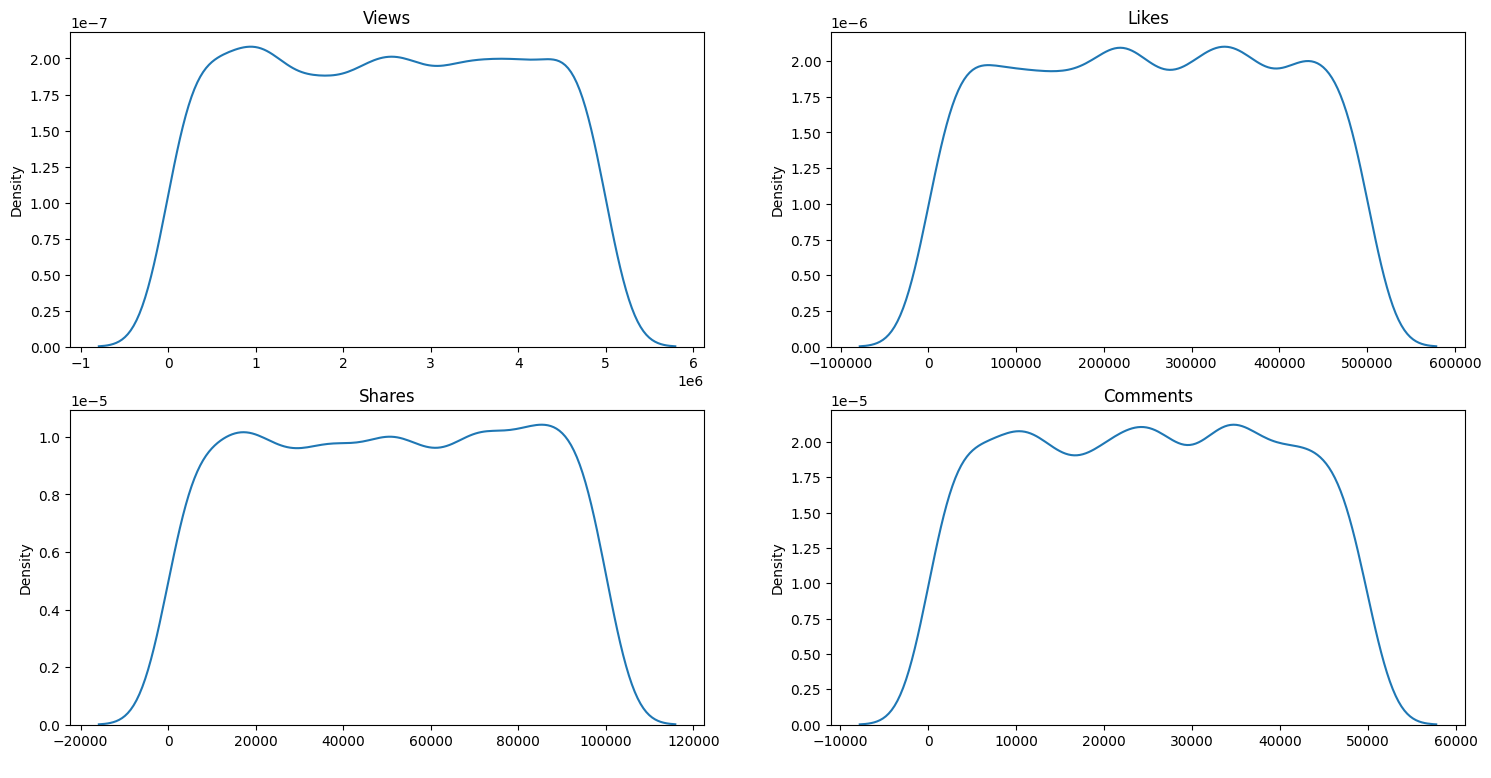

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(18, 9))
axes = axes.flatten()
for idx, col in enumerate(numerical_columns):
    sns.kdeplot(
                data=df[col],
                ax=axes[idx]
                )
    axes[idx].set_title(col)
    axes[idx].set_xlabel(' ')
plt.show()

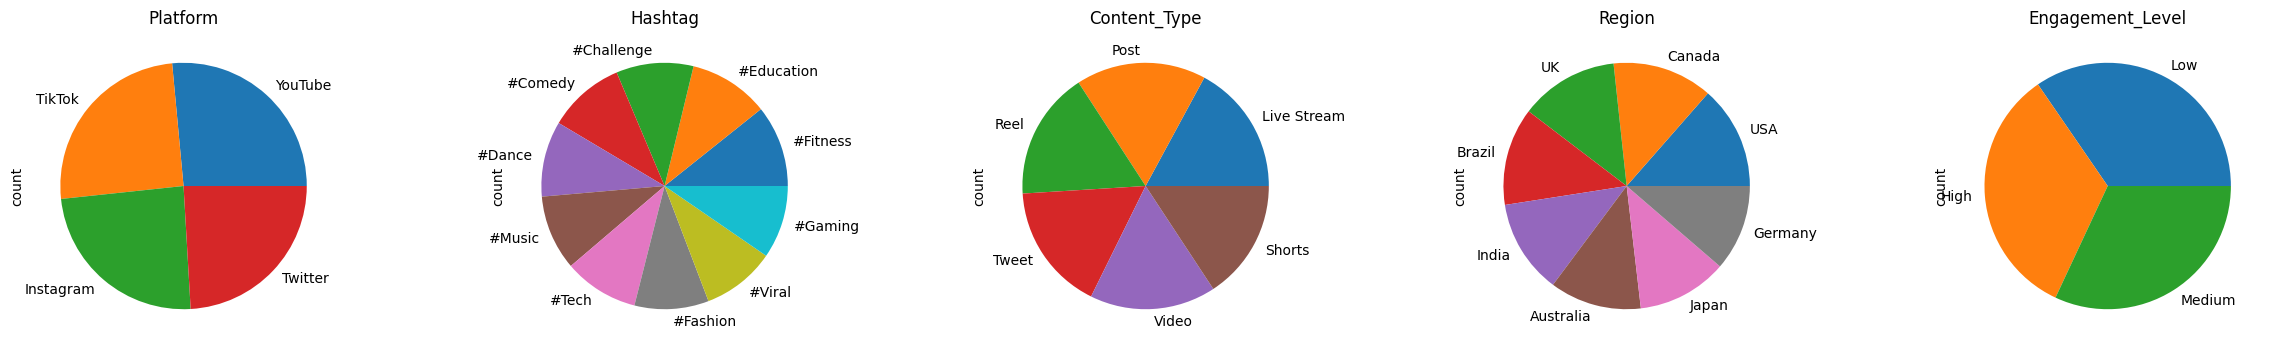

In [54]:
fig, axes = plt.subplots(1, 5, figsize=(30, 4))

for idx, col in enumerate(categorical_columns):
    df[col].value_counts().plot(
                                kind='pie',
                                ax=axes[idx]
                                )
    axes[idx].set_title(col)
    axes[idx].set_xlabel('')

plt.show()

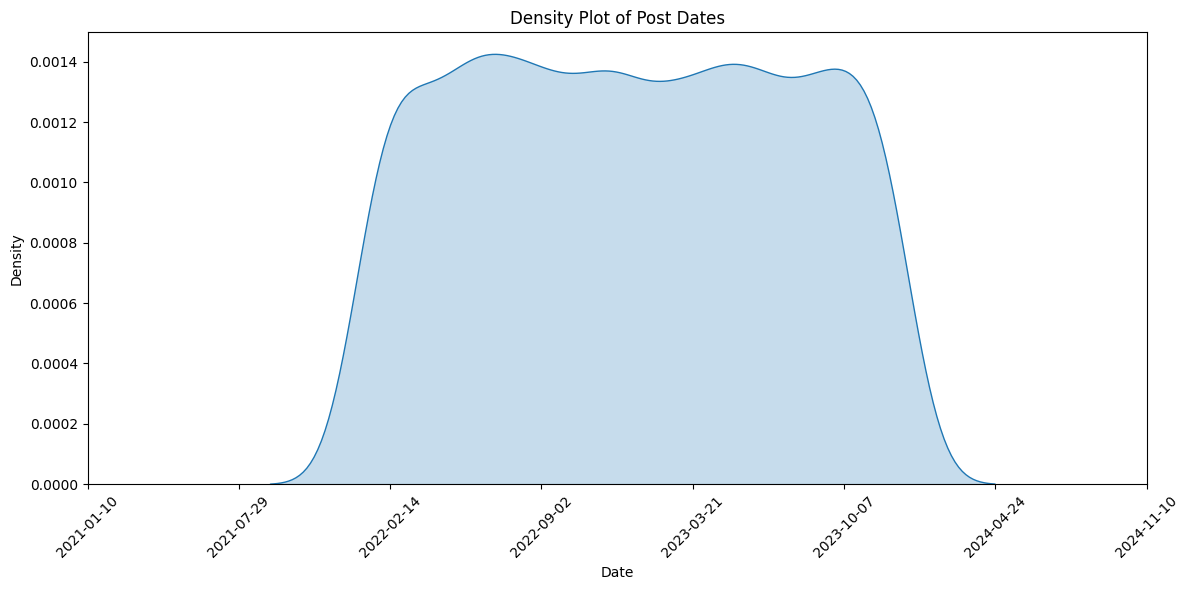

In [55]:
# Density plot for Post_Date column
df['Post_Date'] = pd.to_datetime(df['Post_Date'])
df['Post_Date_ordinal'] = df['Post_Date'].map(lambda x: x.toordinal())
plt.figure(figsize=(12, 6))
sns.kdeplot(df['Post_Date_ordinal'], fill=True)
plt.title('Density Plot of Post Dates')
plt.xlabel('Date')
plt.ylabel('Density')
xticks = plt.xticks()[0]
labels = [datetime.date.fromordinal(int(x)).strftime('%Y-%m-%d') for x in xticks] # convert ordinal xticks back to calendar dates.
plt.xticks(xticks, labels, rotation=45)
plt.tight_layout()
plt.show()

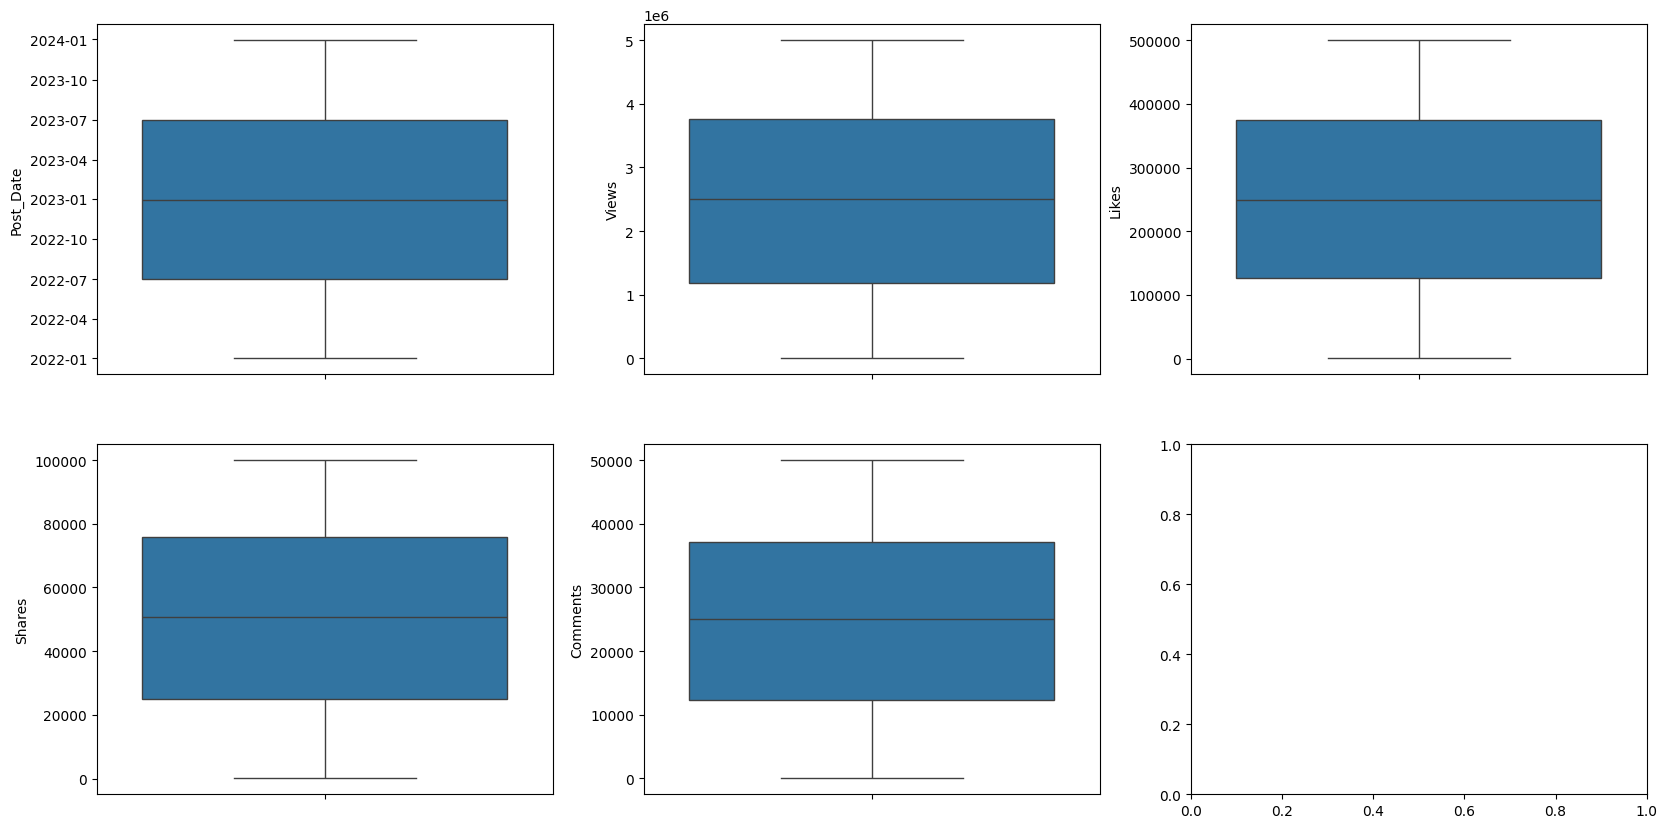

In [56]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

sns.boxplot(data=df['Post_Date'], ax=axes[0,0])
sns.boxplot(data=df['Views'], ax=axes[0,1])
sns.boxplot(data=df['Likes'], ax=axes[0,2])
sns.boxplot(data=df['Shares'], ax=axes[1,0])
sns.boxplot(data=df['Comments'], ax=axes[1,1])


plt.show()


#### Outlier Detection

##### Empirical Rule / 3-Sigma Rule

In [57]:
def find_anomaly_empirical(data):

    mean = data.mean()
    std = data.std()
    upper_bound = mean + (3 * std)
    lower_bound = mean - (3 * std)

    return (data > upper_bound) | (data < lower_bound)

In [58]:
for col in numerical_columns:
    n_outliers = find_anomaly_empirical(df[col]).sum()
    n_outlier_percentage = round(n_outliers / len(df), 3)
    print(f"{col} : {n_outliers} outliers ({n_outlier_percentage} %)")

Views : 0 outliers (0.0 %)
Likes : 0 outliers (0.0 %)
Shares : 0 outliers (0.0 %)
Comments : 0 outliers (0.0 %)


##### IQR Method

In [59]:
def find_anomaly_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    IQR = Q3 - Q1

    upper_bound = Q3 + 1.5 * IQR 
    lower_bound = Q1 - 1.5 * IQR 

    return (data > upper_bound) | (data < lower_bound)

In [60]:
for col in numerical_columns:
    n_outliers = find_anomaly_iqr(df[col]).sum()
    n_outlier_percentage = round(n_outliers / len(df), 3)
    print(f"{col} : {n_outliers} outliers ({n_outlier_percentage} %)")

Views : 0 outliers (0.0 %)
Likes : 0 outliers (0.0 %)
Shares : 0 outliers (0.0 %)
Comments : 0 outliers (0.0 %)


Accordng to the above data there is no misssing values and outliers for this dataset

#### Remove Unnecessory columns

In [61]:
df.head(1)

,Post_ID,Post_Date,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level,Post_Date_ordinal
0,Post_1,2022-01-13,TikTok,#Challenge,Video,UK,4163464,339431,53135,19346,High,738168


In [62]:

df = df.drop(columns=['Post_ID', 'Post_Date_ordinal'])
if 'Post_Date' in df.columns:
    df['Post_Date'] = pd.to_datetime(df['Post_Date'])
    print("\nConverted Post_Date to datetime objects.")


Converted Post_Date to datetime objects.


In [63]:
df.head(0)

,Post_Date,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level


#### Feature Engineering

In [64]:
# Date Features
df['Month'] = df['Post_Date'].dt.month
df['DayOfWeek'] = df['Post_Date'].dt.dayofweek
df['Is_Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
print("Added Date Features: Month, DayOfWeek, Is_Weekend")

# Interaction Features
# Avoid division by zero by adding a small epsilon if needed, though Views should be > 0
df['Likes_Per_View'] = df['Likes'] / df['Views']
df['Shares_Per_View'] = df['Shares'] / df['Views']
df['Comments_Per_View'] = df['Comments'] / df['Views']
df['Engagement_Rate'] = ((df['Likes'] + df['Shares'] + df['Comments']) / df['Views']) * 100
print("Added Interaction Features: Likes_Per_View, Shares_Per_View, Comments_Per_View, Engagement_Rate")

# Categorical Encoding (One-Hot Encoding)
# We use One-Hot Encoding for nominal variables to avoid ordinality assumptions
categorical_cols = ['Platform', 'Hashtag', 'Content_Type', 'Region']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print(f"\nDataframe shape after One-Hot Encoding: {df_encoded.shape}")

# Encode Target Variable for Classification (Engagement_Level)
# Redefine Engagement_Level based on Engagement_Rate quantiles to ensure consistency and learnability
# Low: Bottom 33%, Medium: Middle 33%, High: Top 33%
df_encoded['Engagement_Level_Encoded'] = pd.qcut(df_encoded['Engagement_Rate'], q=3, labels=[0, 1, 2])
print("Redefined Engagement_Level based on Engagement_Rate quantiles (0: Low, 1: Medium, 2: High).")

Added Date Features: Month, DayOfWeek, Is_Weekend
Added Interaction Features: Likes_Per_View, Shares_Per_View, Comments_Per_View, Engagement_Rate

Dataframe shape after One-Hot Encoding: (5000, 37)
Redefined Engagement_Level based on Engagement_Rate quantiles (0: Low, 1: Medium, 2: High).


In [65]:
df.head()

,Post_Date,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level,Month,DayOfWeek,Is_Weekend,Likes_Per_View,Shares_Per_View,Comments_Per_View,Engagement_Rate
0,2022-01-13,TikTok,#Challenge,Video,UK,4163464,339431,53135,19346,High,1,3,0,0.081526,0.012762,0.004647,9.893493
1,2022-05-13,Instagram,#Education,Shorts,India,4155940,215240,65860,27239,Medium,5,4,0,0.051791,0.015847,0.006554,7.419236
2,2022-01-07,Twitter,#Challenge,Video,Brazil,3666211,327143,39423,36223,Medium,1,4,0,0.089232,0.010753,0.009880,10.986520
3,2022-12-05,YouTube,#Education,Shorts,Australia,917951,127125,11687,36806,Low,12,0,0,0.138488,0.012732,0.040096,19.131522
4,2023-03-23,TikTok,#Dance,Post,Brazil,64866,171361,69581,6376,Medium,3,3,0,2.641769,1.072688,0.098295,381.275244


## Saving Processed Data

In [67]:
# Drop original non-numeric columns that are not needed for modeling
cols_to_drop = ['Post_Date', 'Engagement_Level']
df_final = df_encoded.drop(columns=cols_to_drop)

# Save to CSV
output_path = 'data/processed/processed_data.csv'
df_final.to_csv(output_path, index=False)
print(f"Processed data saved to {output_path}")
display(df_final.head())

Processed data saved to data/processed/processed_data.csv


,Views,Likes,Shares,Comments,Month,DayOfWeek,Is_Weekend,Likes_Per_View,Shares_Per_View,Comments_Per_View,Engagement_Rate,Platform_TikTok,Platform_Twitter,Platform_YouTube,Hashtag_#Comedy,Hashtag_#Dance,Hashtag_#Education,Hashtag_#Fashion,Hashtag_#Fitness,Hashtag_#Gaming,Hashtag_#Music,Hashtag_#Tech,Hashtag_#Viral,Content_Type_Post,Content_Type_Reel,Content_Type_Shorts,Content_Type_Tweet,Content_Type_Video,Region_Brazil,Region_Canada,Region_Germany,Region_India,Region_Japan,Region_UK,Region_USA,Engagement_Level_Encoded
0,4163464,339431,53135,19346,1,3,0,0.081526,0.012762,0.004647,9.893493,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,1
1,4155940,215240,65860,27239,5,4,0,0.051791,0.015847,0.006554,7.419236,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,0
2,3666211,327143,39423,36223,1,4,0,0.089232,0.010753,0.009880,10.986520,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,1
3,917951,127125,11687,36806,12,0,0,0.138488,0.012732,0.040096,19.131522,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,1
4,64866,171361,69581,6376,3,3,0,2.641769,1.072688,0.098295,381.275244,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,2
